In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_csv_file(filename):
    return pd.read_csv(filename)
fd_train = load_csv_file("data/Train.csv")
fd_test =  load_csv_file("data/Test.csv")

In [3]:
def get_commmon_columns():
    return ['id', 'date', 'flight_id', 'departure_point', 'arrival_point', 'departure_time', 'arrival_time', 'flight_status', 'aircraft_code']

def rename_colums(fd_train, extra_columns):
    columns = get_commmon_columns() + extra_columns
    fd_train.columns = columns
    return fd_train

fd_train = rename_colums(fd_train, ["target"])
fd_test = rename_colums(fd_test,[])

In [4]:
def add_column_duration(fd_train):
    fd_train['departure_time'] = pd.to_datetime(fd_train['departure_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    fd_train['arrival_time'] = pd.to_datetime(fd_train['arrival_time'], format='%Y-%m-%d %H.%M.%S', errors='coerce')
    fd_train['duration'] = (pd.to_datetime(fd_train['arrival_time']) - pd.to_datetime(fd_train['departure_time'])).dt.total_seconds()
    return fd_train

In [6]:
def prepared_train_data(final_df):
    final_df = add_column_duration(fd_train)
    ## Select records which has less than 20hrs long duration
    ## Filter records which have delay(target) between 1minute to 3hrs
    final_df = fd_train[fd_train["duration"] < 68400]
    df_non_zeros_without_outliers = final_df[(final_df['target'] > 0) & (final_df['target'] < 165)]
    all_zeros = final_df[final_df['target'] == 0]

    # Create a copy of all_zeros and assign random negative values between -1 and -165 to 'target'
    all_zeros_negative = all_zeros.copy()
    positive_targets = df_non_zeros_without_outliers[df_non_zeros_without_outliers['target'] > 0]['target'].values

    all_zeros_negative['target'] = -np.random.choice(positive_targets, size=len(all_zeros_negative), replace=True)
    all_zeros_pos_neg = pd.concat([all_zeros_negative, df_non_zeros_without_outliers], axis=0, ignore_index=True)
    all_zeros_pos_neg.drop(["id", "flight_id", "date"], inplace=True, axis=1)
    return all_zeros_pos_neg


In [7]:
df = prepared_train_data(fd_train)
df.head()

,departure_point,arrival_point,departure_time,arrival_time,flight_status,aircraft_code,target,duration
0,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,-25.0,9300.0
1,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,-33.0,10200.0
2,TUN,MED,2016-01-20 19:40:00,2016-01-21 00:00:00,ATA,TU 320IMR,-14.0,15600.0
3,IST,TUN,2016-01-21 20:10:00,2016-01-21 23:00:00,ATA,TU 320IMU,-35.0,10200.0
4,CMN,TUN,2016-01-22 17:45:00,2016-01-22 20:10:00,ATA,TU 320IMR,-20.0,8700.0


In [8]:
df.to_csv("data/preprocessed_train_data.csv")

In [9]:
def prepared_test_data(final_test_df):
    final_test_df.drop(["flight_id", "date"], inplace=True, axis=1)
    return final_test_df

<Axes: xlabel='target', ylabel='Density'>

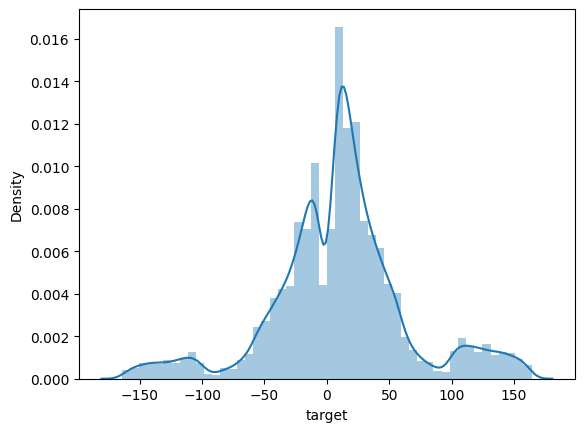

In [9]:
sns.distplot(df["target"], kde=True)

In [10]:
fd = prepared_train_data(fd_train)
fd.head()

,departure_point,arrival_point,departure_time,arrival_time,flight_status,aircraft_code,target,duration
0,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,-9.0,9300.0
1,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,-27.0,10200.0
2,TUN,MED,2016-01-20 19:40:00,2016-01-21 00:00:00,ATA,TU 320IMR,-50.0,15600.0
3,IST,TUN,2016-01-21 20:10:00,2016-01-21 23:00:00,ATA,TU 320IMU,-18.0,10200.0
4,CMN,TUN,2016-01-22 17:45:00,2016-01-22 20:10:00,ATA,TU 320IMR,-23.0,8700.0


In [11]:
df_test = prepared_test_data(fd_test)
final_df = add_column_duration(df_test)

final_df.to_csv("data/preprocessed_test_data.csv")